# Estimation of level sets with BoTorch

following the entry level tutorial here https://botorch.org but I have also browsed extensively along Bite-sized and full-loop tutorials

## 1. Low dimension / low data (no fancy sampling)

Problem in 1-d: $f_{BlackBox}(x) = 2*sin(x) - x$ at threshold $t=3.$

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import Tensor
from botorch.utils import standardize

def f(x: Tensor):
    return torch.sin(7*x)
    
t = 0.25

#generate truth data
true_x = torch.arange(0, 1, 0.01).double()
true_y = f(true_x).double()

#generate std training data
train_x = torch.rand(2,1).double()
train_y = f(train_x).double()
train_y_std = standardize(train_y).double()
noise = torch.full_like(train_y, 0.)

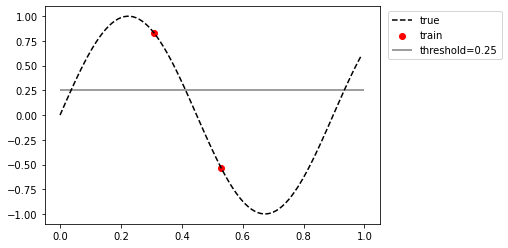

In [2]:
# helper function
from typing import Optional
def make_plot(mean: Optional=None, std: Optional=None, new_x: Optional=None):
    if mean is not None:
        plt.plot(true_x, mean, color='blue', label='mean');
    if std is not None:
        plt.fill_between(true_x, mean-std, mean+std, color='lightblue', label='std');
    if new_x is not None:
        plt.scatter(new_x.detach().numpy(), f(new_x).detach().numpy(), color='red', marker='o')

    plt.plot(true_x, true_y, color='black', linestyle='--', label='true');
    plt.scatter(train_x, train_y, color='red', marker='o', label='train')
    plt.hlines(t, 0, 1, color='grey', label=f'threshold={t}');
    lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    
make_plot()

In [3]:
#train model 
from botorch.models import FixedNoiseGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood

gp = FixedNoiseGP(train_x, train_y, noise);
mll = ExactMarginalLogLikelihood(gp.likelihood, gp);
fit_gpytorch_model(mll);

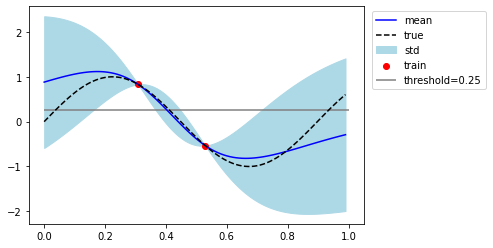

In [4]:
#plot fit
import numpy as np
mean = gp.posterior(true_x).mean.detach().numpy().flatten()
std = np.sqrt(gp.posterior(true_x).variance.detach().numpy().flatten())

make_plot(mean=mean, std=std)

In [5]:
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.acquisition.objective import ScalarizedObjective
from botorch.models.model import Model
import math

#helper function
def cdf(mu, sigma, t):
    mu_reshape = torch.stack([mu,mu], dim=1)
    sigma_reshape = torch.stack([sigma, sigma], dim=1)
    erf = torch.erf((t - mu_reshape) * (sigma_reshape).reciprocal() / math.sqrt(2))
    cdf = 0.5 * (1 + erf)
    return cdf 


class MaximumEntropySearch(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: Model,
        threshold: Tensor,
        objective: Optional[ScalarizedObjective] = None,
        maximize: bool = True,
    ) -> None:
        super().__init__(model=model, objective=objective)
        # self.maximize = maximize
        self.thr = threshold
        infty = 1E10
        self.thresholds = [-infty] + self.thr.tolist() + [infty]
        self.pairs_thresholds = list(zip(self.thresholds, self.thresholds[1:]))
        self.pairs_thresholds = [torch.Tensor(pair) for pair in self.pairs_thresholds]

    def forward(self, X: Tensor):
        X.requires_grad=True
        posterior = self._get_posterior(X=X)
        batch_shape = X.shape[:-2]
        mean = posterior.mean.view(batch_shape).double()
        std = torch.square(posterior.variance.view(batch_shape).double())
        #probability of image being between thresholds
        p = cdf(mean, std, self.pairs_thresholds[1]) - cdf(mean, std, self.pairs_thresholds[0])
        probs = torch.cat([p, 1-p])
        #create bernoulli distribution
        distr = torch.distributions.Categorical(probs)
        #entropy
        entropy = distr.entropy().view(-1)
        return entropy

In [6]:
from botorch.optim import optimize_acqf
bounds = torch.stack([torch.zeros(1), torch.ones(1)]).double()
threshold = torch.Tensor([t]) 
threshold.requires_grad=True
N_TRIALS = 3
N_Q = 1
N_RESTART = 1
N_SAMPLES = 1 

for i in range(1, N_TRIALS+1):
    #find suggestions
    MES = MaximumEntropySearch(gp, threshold=threshold)
    
    candidate, acq_value = optimize_acqf(
        MES, bounds=bounds, q=N_Q, num_restarts=N_Q, raw_samples=N_SAMPLES,
    )
    print(f"Suggestion iteration {i}: x_new = {candidate.item()} with acq_value = {acq_value}")
    
    #update training set
    train_x = torch.vstack([train_x,candidate[0]])
    train_y = torch.vstack([train_y,f(candidate[0])])
    
    #update fit
    noise = torch.full_like(train_y, 0.)
    gp = FixedNoiseGP(train_x, train_y, noise);
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp);
    fit_gpytorch_model(mll);    
    
    #plot fit
    mean = gp.posterior(true_x).mean.detach().numpy().flatten()
    std = np.sqrt(gp.posterior(true_x).variance.detach().numpy().flatten())
    make_plot(mean=mean, std=std, new_x = candidate)
    plt.show()
    

Suggestion iteration 1: x_new = 1.0 with acq_value = 0.6919530492144497


RuntimeError: Trying to backward through the graph a second time (or directly access saved variables after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved variables after calling backward.